In today's post we're going to see how to use [xarray](http://xarray.pydata.org/) multicore capabilities to access a fairly large weather dataset using Python. To illustrate our purpose, we'll look at 15 years of solar radiations provided by the ECMWF. It takes a while to retrieve such a large dataset from the ECMWF, so I'll just give [a direct link to a file with 15 years of data](https://drive.google.com/file/d/1WNFOnPoHa-R6ur9F9KiHYJDNgI49MJvw/view?usp=sharing) that I've previously retrieved from the ECMWF (9.5GB). While your downloading this file, read on to understand how you can retrieve your own datasets from the ECMWF.

## Retrieving ECMWF data

The ECMWF provides a convenient [Python library to access its dataset](https://software.ecmwf.int/wiki/display/WEBAPI/Access+ECMWF+Public+Datasets). In order to use it you'll need to create an ECMWF account and [install your ECMWF key](https://software.ecmwf.int/wiki/display/WEBAPI/Access+ECMWF+Public+Datasets#AccessECMWFPublicDatasets-key). Please read [the instructions on the ECMWF website](https://software.ecmwf.int/wiki/display/WEBAPI/Access+ECMWF+Public+Datasets) for more info on setting up this library.

Once the library is properly installed on your system, you can use it to fetch a dataset with a bit of Python code. For instance here, we request downward solar radiation for the first 3 months of 2017:

```python
from ecmwfapi import ECMWFDataServer
server = ECMWFDataServer()
server.retrieve({
    "class": "ei",
    "dataset": "interim",
    "date": "2017-01-01/to/2017-03-31",
    "expver": "1",
    "grid": "0.75/0.75",
    "levtype": "sfc",
    "param": "169.128",
    "step": "3",
    "stream": "oper",
    "time": "12:00:00",
    "type": "fc",
    "target": "solor-radiation-downward.grib",
})
```

Now that you know how to retrieve datasets to suit your own needs, let's see how we can use xarray to access them.

## Accessing data with xarray

Hopefully by now you'll have downloaded the dataset and placed it in a folder near your Python script or notebook. We're going to open the dataset I've provided with xarray and the pynio engine.

In [1]:
import xarray as xr

In [2]:
ds = xr.open_dataset("data/ensoleillement-2002-2016.grib", engine="pynio")
ds.SSRD_GDS0_SFC

<xarray.DataArray 'SSRD_GDS0_SFC' (initial_time0_hours: 10958, forecast_time1: 4, g0_lat_2: 241, g0_lon_3: 480)>
[5070485760 values with dtype=float32]
Coordinates:
  * g0_lat_2             (g0_lat_2) float32 90.0 89.25 88.5 87.75 87.0 86.25 ...
  * forecast_time1       (forecast_time1) timedelta64[ns] 03:00:00 06:00:00 ...
  * g0_lon_3             (g0_lon_3) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 ...
  * initial_time0_hours  (initial_time0_hours) datetime64[ns] 2002-01-01 ...
Attributes:
    gds_grid_type:            [0]
    center:                   European Center for Medium-Range Weather Foreca...
    parameter_table_version:  [128]
    level_indicator:          [1]
    long_name:                Surface solar radiation downwards
    units:                    W m**-2 s
    parameter_number:         [169]

Let's get first grid we have in this dataset:

In [3]:
midnight = ds.SSRD_GDS0_SFC[0,0]
midnight.initial_time0_hours

<xarray.DataArray 'initial_time0_hours' ()>
array('2002-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    forecast_time1       timedelta64[ns] 03:00:00
    initial_time0_hours  datetime64[ns] 2002-01-01
Attributes:
    long_name:  initial time

This gives us solar radiation at 00:00. Let's plot it:

In [4]:
midnight.plot(aspect=2,size=5);

Now let's plot the same grid at 12:00.

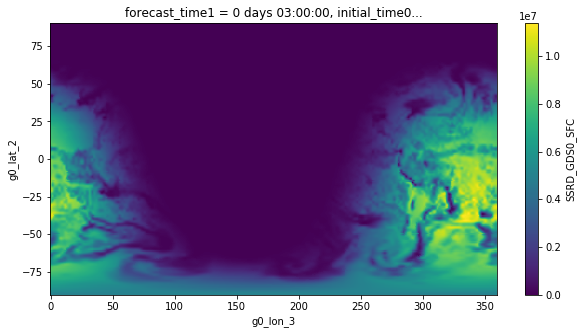

In [5]:
noon = ds.SSRD_GDS0_SFC[1,0]
noon.plot(aspect=2,size=5);

Accessing individual grids of data like this is fairly quick. Now we're going to extract time series spanning 15 years.

## Extracting a time series

So we select a time series of values near a given point as provided by the 3am run:

In [6]:
lat, lon = 43.6, 1.44  # City of Toulouse, France
da = ds.SSRD_GDS0_SFC.sel(forecast_time1="03:00:00", g0_lat_2=lat, g0_lon_3=lon,
                          method='nearest')

And let's take only values at 12:00 using a Python slice step:

In [7]:
da = da[1::2]

Note that at this point, we haven't actually read any data because xarray loads data lazily, only when it's needed. Now let's plot this time series and measure how much time it takes.

CPU times: user 25.9 s, sys: 285 ms, total: 26.2 s
Wall time: 26.2 s


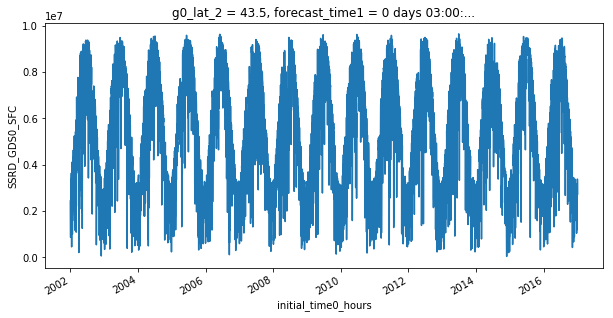

In [8]:
%%time

da.plot(aspect=2, size=5);

26.6 seconds is not too bad, if you have a multi-core computer, xarray can do better.

## Enabling multicore processing

To parallelize its work, xarray relies on another library named Dask. Let's tell Dask to enable multiprocessing:

In [9]:
import dask.multiprocessing
dask.set_options(get=dask.multiprocessing.get);  # Activation du parallélisme multicoeurs

Now we're going to split our dataset in chunks (one chunk per CPU core) that can be processed in parallel:

In [10]:
import multiprocessing
chunk_size = ds.initial_time0_hours.size / multiprocessing.cpu_count()
chunked_ds = ds.chunk({"initial_time0_hours": chunk_size})
chunked_da = chunked_ds.SSRD_GDS0_SFC.sel(forecast_time1="03:00:00", g0_lat_2=lat, g0_lon_3=lon,
                                          method='nearest')
chunked_da = chunked_da[1::2]

Let's plot our time series again, to observe how faster it is now:

CPU times: user 86.6 ms, sys: 44.4 ms, total: 131 ms
Wall time: 4.83 s


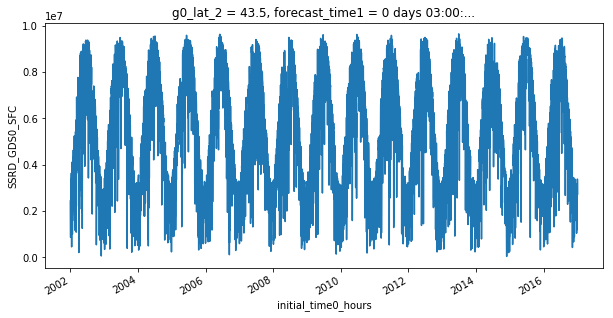

In [12]:
%%time

chunked_da.plot(aspect=2, size=5);

As you can see, it is now much faster because distribute the work on all the available CPU cores.
Don't hesitate to use a system monitoring tool such as the `top` command to observe by yourself how xarray spawns a Python process for each of your CPU cores:

![Running the top command](/images/xarray-top.png)